In [35]:
# Data processing
import numpy as np
import pandas as pd
import xarray as xr
import iris
import iris.pandas
import warnings
warnings.filterwarnings('ignore', module='iris')
import dateutil.parser
from datetime import datetime, timedelta
from pathlib import Path
from shapely.geometry import Point, Polygon
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
# Plotting parameters
plt.rcParams['mathtext.default'] = 'regular'
def m2km(x, pos):
    '''Convert meters to kilometers when plotting axis labels'''
    return int(x*1e-3) #'{:1.1f}'.format(x*1e-3)
savefig = True

#### Read data

In [36]:
path_to_atom = Path('../../../../../../obs/ATom/nc/data')
# Select flights
fname_atom_flight = 'MER-WAS_DC8_201608*.nc'
# Read ATom data
atom_dsinf = xr.open_mfdataset(sorted(path_to_atom.glob(fname_atom_flight)), decode_times=True)
atom_dsmms = xr.open_mfdataset(sorted(path_to_atom.glob(fname_atom_flight)), group='MMS', decode_cf=True)
atom_dswas = xr.open_mfdataset(sorted(path_to_atom.glob(fname_atom_flight)), group='WAS', decode_cf=True)

In [37]:
# Choose UKCA run
ukca_run_name = 'az166a'
ukca_run_yrmn = 'pm2016aug'
compared_common_id = '160801_160823_1608_merge'
path_to_ukca = Path('../../../../processed') / ukca_run_name
fname_ukca_run = f'{ukca_run_name}_{ukca_run_yrmn}_relvl.nc'
# Read UKCA data
cb_c2h6 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'c2h6')
cb_c3h8 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'c3h8')
cb_nc4h10 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'nc4h10')
cb_ic4h10 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'ic4h10')
cb_nc5h12 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'nc5h12')
cb_ic5h12 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'ic5h12')
cb_meono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'meono2')
cb_sbuono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'sbuono2')
cb_n2peono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'n2peono2')
cb_n3peono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'n3peono2')
cb_ipeono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'ipeono2')
# Load UKCA geospatial coordinates
ukca_lats = iris.load_cube(str(Path('../../../../data') / 'ukca_coords_n96e_marcus_180705.nc'), 'mass_fraction_of_ozone_in_air').coord('latitude')
ukca_lons = iris.load_cube(str(Path('../../../../data') / 'ukca_coords_n96e_marcus_180705.nc'), 'mass_fraction_of_ozone_in_air').coord('longitude')

In [38]:
# Path to figures
path_to_figs = Path('../../../../../../results') / ukca_run_name / compared_common_id
path_to_figs.mkdir(exist_ok=True) # create a new folder if it doesn't exist

#### Select geographical region for spacial averaging

In [5]:
# Extract datetimes from ATom data
atom_datetime = atom_dsinf.time.values.astype('<M8[us]').astype(datetime)
atom_date_strt = atom_datetime[0]
atom_date_stop = atom_datetime[-1]
# Extract spatial coordinates from ATom data
sample_lats = np.asarray(atom_dsmms.G_LAT.data) 
sample_lons = np.asarray(atom_dsmms.G_LONG.data+360)
sample_alts = np.asarray(atom_dsmms.G_ALT.data)
# Create UKCA lat lon grid
grid_lons, grid_lats = np.meshgrid(ukca_lons.points, ukca_lats.points)
# Construct pairs of coordinate points
sample_lon_lat_points = []
for i, j in zip(sample_lons, sample_lats):
    sample_lon_lat_points.append(Point(i, j))

In [6]:
# Define a geographical region
r1_llon, r1_ulon = 195.9375, 205.3125
r1_llat, r1_ulat = 21.875, 53.125
r1 = Polygon([(r1_llon, r1_llat), (r1_llon, r1_ulat), (r1_ulon, r1_ulat), (r1_ulon, r1_llat)])
r2_llon, r2_ulon = 180.9375, 201.5625
r2_llat, r2_ulat = -40.625, 20.625
r2 = Polygon([(r2_llon, r2_llat), (r2_llon, r2_ulat), (r2_ulon, r2_ulat), (r2_ulon, r2_llat)])
r3_llon, r3_ulon = 180.9375, 285.9375
r3_llat, r3_ulat = -70.625, -50.625
r3 = Polygon([(r3_llon, r3_llat), (r3_llon, r3_ulat), (r3_ulon, r3_ulat), (r3_ulon, r3_llat)])
r4_llon, r4_ulon = 312.1875, 334.6875
r4_llat, r4_ulat = -45.625, -25.625
r4 = Polygon([(r4_llon, r4_llat), (r4_llon, r4_ulat), (r4_ulon, r4_ulat), (r4_ulon, r4_llat)])
r5_llon, r5_ulon = 332.8125, 344.0625
r5_llat, r5_ulat = -6.875, 36.875
r5 = Polygon([(r5_llon, r5_llat), (r5_llon, r5_ulat), (r5_ulon, r5_ulat), (r5_ulon, r5_llat)])
r6_llon, r6_ulon = 321.5625, 338.4375
r6_llat, r6_ulat = 38.125, 63.125
r6 = Polygon([(r6_llon, r6_llat), (r6_llon, r6_ulat), (r6_ulon, r6_ulat), (r6_ulon, r6_llat)])
r7_llon, r7_ulon = 269.0625, 321.5625
r7_llat, r7_ulat = 46.875, 81.875
r7 = Polygon([(r7_llon, r7_llat), (r7_llon, r7_ulat), (r7_ulon, r7_ulat), (r7_ulon, r7_llat)])
r8_llon, r8_ulon = 237.1875, 269.0625
r8_llat, r8_ulat = 31.875, 50.625
r8 = Polygon([(r8_llon, r8_llat), (r8_llon, r8_ulat), (r8_ulon, r8_ulat), (r8_ulon, r8_llat)])
r9_llon, r9_ulon = 210.9375, 237.1875
r9_llat, r9_ulat = 53.125, 81.875
r9 = Polygon([(r9_llon, r9_llat), (r9_llon, r9_ulat), (r9_ulon, r9_ulat), (r9_ulon, r9_llat)])
# Find points within a region
r1_points_within = []
r2_points_within = []
r3_points_within = []
r4_points_within = []
r5_points_within = []
r6_points_within = []
r7_points_within = []
r8_points_within = []
r9_points_within = []
for p in sample_lon_lat_points:
    r1_points_within.append(p.within(r1))
    r2_points_within.append(p.within(r2))
    r3_points_within.append(p.within(r3))
    r4_points_within.append(p.within(r4))
    r5_points_within.append(p.within(r5))
    r6_points_within.append(p.within(r6))
    r7_points_within.append(p.within(r7))
    r8_points_within.append(p.within(r8))
    r9_points_within.append(p.within(r9))
# Combine points within and region corners into lists
points_within_regions = [r1_points_within, r2_points_within, r3_points_within, r4_points_within, r5_points_within, r6_points_within, r7_points_within, r8_points_within, r9_points_within]
ukca_regions_corners = [[r1_llon, r1_ulon, r1_llat, r1_ulat], [r2_llon, r2_ulon, r2_llat, r2_ulat], [r3_llon, r3_ulon, r3_llat, r3_ulat], 
                        [r4_llon, r4_ulon, r4_llat, r4_ulat], [r5_llon, r5_ulon, r5_llat, r5_ulat], [r6_llon, r6_ulon, r6_llat, r6_ulat], 
                        [r7_llon, r7_ulon, r7_llat, r7_ulat], [r8_llon, r8_ulon, r8_llat, r8_ulat], [r9_llon, r9_ulon, r9_llat, r9_ulat]]
region_names = ['North Pacific', 'Central Pacific', 'South Pacific', 'South East Atlantic', 'Central Atlantic', 'North Atlantic', 'East Canada, Greenland', 'Central and West USA', 'West Canada, Alaska']

In [7]:
def plot_region(lons, lats, points_within, ukca_llon, ukca_ulon, ukca_llat, ukca_ulat, llon, ulon, llat, ulat):
    if (abs(llon) <= 180 <= abs(ulon)) or (abs(llon) >= 180 >= abs(ulon)):
        projection = ccrs.PlateCarree(central_longitude=180)
    else:
        projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(projection=projection), facecolor='w')
    ax.scatter(lons, lats, transform=ccrs.PlateCarree())
    ax.scatter(lons[points_within], lats[points_within], color='r', transform=ccrs.PlateCarree())
    ax.add_patch(mpatches.Rectangle(xy=[ukca_llon, ukca_llat], width=ukca_ulon-ukca_llon, height=ukca_ulat-ukca_llat, facecolor='b', alpha=0.2, transform=ccrs.PlateCarree()))
#     ax.plot(grid_lons, grid_lats, color='b', alpha=0.7, transform=ccrs.PlateCarree())
#     ax.plot(grid_lons.T, grid_lats.T, color='b', alpha=0.7, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([llon, ulon, llat, ulat], crs=ccrs.PlateCarree())
    ax.gridlines(draw_labels=False)

In [8]:
# plot_region(sample_lons, sample_lats, r1_points_within, r1_llon, r1_ulon, r1_llat, r1_ulat, -170, -150, 15, 60)

In [9]:
# plot_region(sample_lons, sample_lats, r2_points_within, r2_llon, r2_ulon, r2_llat, r2_ulat, -200, -120, -50, 40)

In [10]:
# plot_region(sample_lons, sample_lats, r3_points_within, r3_llon, r3_ulon, r3_llat, r3_ulat, -190, -60, -90, 0)

In [11]:
# plot_region(sample_lons, sample_lats, r4_points_within, r4_llon, r4_ulon, r4_llat, r4_ulat, -80, 20, -60, 0)

In [12]:
# plot_region(sample_lons, sample_lats, r5_points_within, r5_llon, r5_ulon, r5_llat, r5_ulat, -80, 20, -60, 60)

In [13]:
# plot_region(sample_lons, sample_lats, r6_points_within, r6_llon, r6_ulon, r6_llat, r6_ulat, -80, 20, 0, 80)

In [14]:
# plot_region(sample_lons, sample_lats, r8_points_within, r8_llon, r8_ulon, r8_llat, r8_ulat, -140, -80, 20, 90)

In [15]:
# plot_region(sample_lons, sample_lats, r9_points_within, r9_llon, r9_ulon, r9_llat, r9_ulat, -170, -80, 20, 90)

In [16]:
def plot_regions(lons, lats, points_within_regions, ukca_regions_corners, llon, ulon, llat, ulat):
    r1_points_within, r2_points_within, r3_points_within, r4_points_within, r5_points_within, r6_points_within, r7_points_within, r8_points_within, r9_points_within = points_within_regions
    [r1_llon, r1_ulon, r1_llat, r1_ulat] = ukca_regions_corners[0]
    [r2_llon, r2_ulon, r2_llat, r2_ulat] = ukca_regions_corners[1]
    [r3_llon, r3_ulon, r3_llat, r3_ulat] = ukca_regions_corners[2]
    [r4_llon, r4_ulon, r4_llat, r4_ulat] = ukca_regions_corners[3]
    [r5_llon, r5_ulon, r5_llat, r5_ulat] = ukca_regions_corners[4]
    [r6_llon, r6_ulon, r6_llat, r6_ulat] = ukca_regions_corners[5]
    [r7_llon, r7_ulon, r7_llat, r7_ulat] = ukca_regions_corners[6]
    [r8_llon, r8_ulon, r8_llat, r8_ulat] = ukca_regions_corners[7]
    [r9_llon, r9_ulon, r9_llat, r9_ulat] = ukca_regions_corners[8]
    
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), facecolor='w')
    ax.scatter(lons, lats, color='k', transform=ccrs.PlateCarree())
    kwargs_sc = dict(color='r', transform=ccrs.PlateCarree())
    ax.scatter(lons[r1_points_within], lats[r1_points_within], **kwargs_sc)
    ax.scatter(lons[r2_points_within], lats[r2_points_within], **kwargs_sc)
    ax.scatter(lons[r3_points_within], lats[r3_points_within], **kwargs_sc)
    ax.scatter(lons[r4_points_within], lats[r4_points_within], **kwargs_sc)
    ax.scatter(lons[r5_points_within], lats[r5_points_within], **kwargs_sc)
    ax.scatter(lons[r6_points_within], lats[r6_points_within], **kwargs_sc)
    ax.scatter(lons[r7_points_within], lats[r7_points_within], **kwargs_sc)
    ax.scatter(lons[r8_points_within], lats[r8_points_within], **kwargs_sc)
    ax.scatter(lons[r9_points_within], lats[r9_points_within], **kwargs_sc)
    kwargs_patch = dict(facecolor='grey', alpha=0.2, edgecolor='k', transform=ccrs.PlateCarree())
    ax.add_patch(mpatches.Rectangle(xy=[r1_llon, r1_llat], width=r1_ulon-r1_llon, height=r1_ulat-r1_llat, **kwargs_patch))
    ax.add_patch(mpatches.Rectangle(xy=[r2_llon, r2_llat], width=r2_ulon-r2_llon, height=r2_ulat-r2_llat, **kwargs_patch))
    ax.add_patch(mpatches.Rectangle(xy=[r3_llon, r3_llat], width=r3_ulon-r3_llon, height=r3_ulat-r3_llat, **kwargs_patch))
    ax.add_patch(mpatches.Rectangle(xy=[r4_llon, r4_llat], width=r4_ulon-r4_llon, height=r4_ulat-r4_llat, **kwargs_patch))
    ax.add_patch(mpatches.Rectangle(xy=[r5_llon, r5_llat], width=r5_ulon-r5_llon, height=r5_ulat-r5_llat, **kwargs_patch))
    ax.add_patch(mpatches.Rectangle(xy=[r6_llon, r6_llat], width=r6_ulon-r6_llon, height=r6_ulat-r6_llat, **kwargs_patch))
    ax.add_patch(mpatches.Rectangle(xy=[r7_llon, r7_llat], width=r7_ulon-r7_llon, height=r7_ulat-r7_llat, **kwargs_patch))
    ax.add_patch(mpatches.Rectangle(xy=[r8_llon, r8_llat], width=r8_ulon-r8_llon, height=r8_ulat-r8_llat, **kwargs_patch))
    ax.add_patch(mpatches.Rectangle(xy=[r9_llon, r9_llat], width=r9_ulon-r9_llon, height=r9_ulat-r9_llat, **kwargs_patch))
    ax.set_title('ATom', loc='right')
    ax.set_title(f'{atom_date_strt.strftime("%b %Y")}', loc='left')
    ax.set_extent([llon, ulon, llat, ulat], crs=ccrs.PlateCarree())
    ax.coastlines()
    if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_regions.png', bbox_inches='tight')

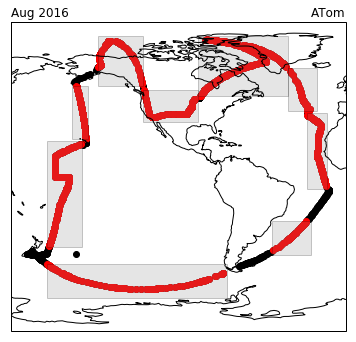

In [17]:
plot_regions(sample_lons, sample_lats, points_within_regions, ukca_regions_corners, -200, -5, -90, 90)

#### Process ATom data

In [18]:
# Convert ATom C2H6, C2H4, C2H2, C3H8, C3H6 to pptvC to match UKCA lumped species, namely C2H6=C2H6+C2H4+C2H2, C3H8=C3H8+C3H6
atom_dswas_c2h6 = atom_dswas['Ethane_WAS']*2 + atom_dswas['Ethene_WAS']*2 + atom_dswas['Ethyne_WAS']*2
atom_dswas_c3h8 = atom_dswas['Propane_WAS']*3 + atom_dswas['Propene_WAS']*3
# Convert xarray dataset with observational data to pandas dataframe
atom_c2h6 = atom_dswas_c2h6.to_dataframe(name='c2h6')
atom_c3h8 = atom_dswas_c3h8.to_dataframe(name='c3h8')
atom_nc4h10 = atom_dswas['n-Butane_WAS'].to_dataframe(name='nc4h10')
atom_ic4h10 = atom_dswas['i-Butane_WAS'].to_dataframe(name='ic4h10')
atom_nc5h12 = atom_dswas['n-Pentane_WAS'].to_dataframe(name='nc5h12')
atom_ic5h12 = atom_dswas['i-Pentane_WAS'].to_dataframe(name='ic5h12')
atom_meono2 = atom_dswas['MeONO2_WAS'].to_dataframe(name='meono2')
atom_sbuono2 = atom_dswas['2-BuONO2_WAS'].to_dataframe(name='sbuono2')
atom_n2peono2 = atom_dswas['2-PenONO2_WAS'].to_dataframe(name='n2peono2')
atom_n3peono2 = atom_dswas['3-PenONO2_WAS'].to_dataframe(name='n3peono2')
atom_ipeono2 = atom_dswas['3-Methyl-2-BuONO2_WAS'].to_dataframe(name='ipeono2')

In [19]:
# # Select longitudes and latitudes where ATom data is available
# lons_c2h6_notnan = np.where(atom_c2h6.Lumped_C2H6_C2H4_C2H2.isna()==False, sample_lons, atom_c2h6.Lumped_C2H6_C2H4_C2H2)
# lats_c2h6_notnan = np.where(atom_c2h6.Lumped_C2H6_C2H4_C2H2.isna()==False, sample_lats, atom_c2h6.Lumped_C2H6_C2H4_C2H2)
# lons_c3h8_notnan = np.where(atom_c3h8.Lumped_C3H8_C3H6.isna()==False, sample_lons, atom_c3h8.Lumped_C3H8_C3H6)
# lats_c3h8_notnan = np.where(atom_c3h8.Lumped_C3H8_C3H6.isna()==False, sample_lats, atom_c3h8.Lumped_C3H8_C3H6)
# lons_nc4h10_notnan = np.where(atom_nc4h10['n-Butane_WAS'].isna()==False, sample_lons, atom_nc4h10['n-Butane_WAS'])
# lats_nc4h10_notnan = np.where(atom_nc4h10['n-Butane_WAS'].isna()==False, sample_lats, atom_nc4h10['n-Butane_WAS'])
# lons_ic4h10_notnan = np.where(atom_ic4h10['i-Butane_WAS'].isna()==False, sample_lons, atom_ic4h10['i-Butane_WAS'])
# lats_ic4h10_notnan = np.where(atom_ic4h10['i-Butane_WAS'].isna()==False, sample_lats, atom_ic4h10['i-Butane_WAS'])
# lons_nc5h12_notnan = np.where(atom_nc5h12['n-Pentane_WAS'].isna()==False, sample_lons, atom_nc5h12['n-Pentane_WAS'])
# lats_nc5h12_notnan = np.where(atom_nc5h12['n-Pentane_WAS'].isna()==False, sample_lats, atom_nc5h12['n-Pentane_WAS'])
# lons_ic5h12_notnan = np.where(atom_ic5h12['i-Pentane_WAS'].isna()==False, sample_lons, atom_ic5h12['i-Pentane_WAS'])
# lats_ic5h12_notnan = np.where(atom_ic5h12['i-Pentane_WAS'].isna()==False, sample_lats, atom_ic5h12['i-Pentane_WAS'])
# lons_meono2_notnan = np.where(atom_meono2['MeONO2_WAS'].isna()==False, sample_lons, atom_meono2['MeONO2_WAS'])
# lats_meono2_notnan = np.where(atom_meono2['MeONO2_WAS'].isna()==False, sample_lats, atom_meono2['MeONO2_WAS'])
# lons_sbuono2_notnan = np.where(atom_sbuono2['2-BuONO2_WAS'].isna()==False, sample_lons, atom_sbuono2['2-BuONO2_WAS'])
# lats_sbuono2_notnan = np.where(atom_sbuono2['2-BuONO2_WAS'].isna()==False, sample_lats, atom_sbuono2['2-BuONO2_WAS'])
# lons_n2peono2_notnan = np.where(atom_n2peono2['2-PenONO2_WAS'].isna()==False, sample_lons, atom_n2peono2['2-PenONO2_WAS'])
# lats_n2peono2_notnan = np.where(atom_n2peono2['2-PenONO2_WAS'].isna()==False, sample_lats, atom_n2peono2['2-PenONO2_WAS'])
# lons_n3peono2_notnan = np.where(atom_n3peono2['3-PenONO2_WAS'].isna()==False, sample_lons, atom_n3peono2['3-PenONO2_WAS'])
# lats_n3peono2_notnan = np.where(atom_n3peono2['3-PenONO2_WAS'].isna()==False, sample_lats, atom_n3peono2['3-PenONO2_WAS'])
# lons_ipeono2_notnan = np.where(atom_ipeono2['3-Methyl-2-BuONO2_WAS'].isna()==False, sample_lons, atom_ipeono2['3-Methyl-2-BuONO2_WAS'])
# lats_ipeono2_notnan = np.where(atom_ipeono2['3-Methyl-2-BuONO2_WAS'].isna()==False, sample_lats, atom_ipeono2['3-Methyl-2-BuONO2_WAS'])

In [20]:
def plot_ts(atom, alts):
    fig, ax = plt.subplots()
    ax.plot(atom, marker='o')
    ax2 = ax.twinx()
    ax2.plot(alts, marker='o', color='grey', linestyle='--')

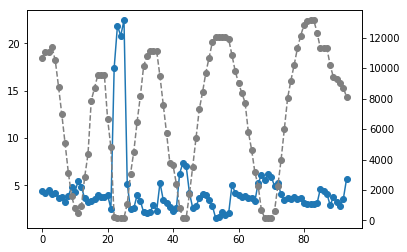

In [21]:
plot_ts(atom_meono2[r1_points_within].values, atom_dsmms.G_ALT[r1_points_within].data)

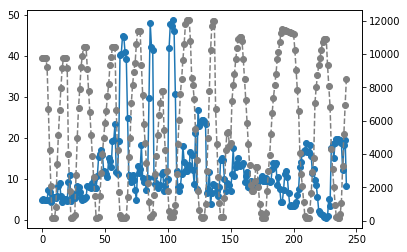

In [22]:
plot_ts(atom_meono2[r2_points_within].values, atom_dsmms.G_ALT[r2_points_within].data)

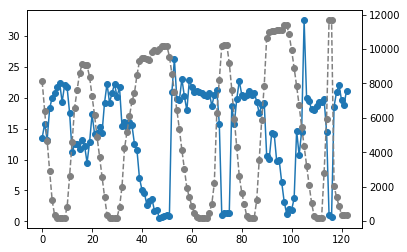

In [23]:
plot_ts(atom_meono2[r3_points_within].values, atom_dsmms.G_ALT[r3_points_within].data)

In [32]:
# Choose bins
alt_bins = np.arange(0, 14000, 500)
alt_bin_inds = np.arange(0, len(alt_bins)-1, 1)
alt_bin_mids = np.arange(250, 13500, 500)
alt_r1_bin_inds = np.digitize(atom_dsmms.G_ALT.data[r1_points_within], alt_bins)
alt_r2_bin_inds = np.digitize(atom_dsmms.G_ALT.data[r2_points_within], alt_bins)
alt_r3_bin_inds = np.digitize(atom_dsmms.G_ALT.data[r3_points_within], alt_bins)
alt_r4_bin_inds = np.digitize(atom_dsmms.G_ALT.data[r4_points_within], alt_bins)
alt_r5_bin_inds = np.digitize(atom_dsmms.G_ALT.data[r5_points_within], alt_bins)
alt_r6_bin_inds = np.digitize(atom_dsmms.G_ALT.data[r6_points_within], alt_bins)
alt_r7_bin_inds = np.digitize(atom_dsmms.G_ALT.data[r7_points_within], alt_bins)
alt_r8_bin_inds = np.digitize(atom_dsmms.G_ALT.data[r8_points_within], alt_bins)
alt_r9_bin_inds = np.digitize(atom_dsmms.G_ALT.data[r9_points_within], alt_bins)
alt_regions_bin_inds = [alt_r1_bin_inds, alt_r2_bin_inds, alt_r3_bin_inds,
                        alt_r4_bin_inds, alt_r5_bin_inds, alt_r6_bin_inds,
                        alt_r7_bin_inds, alt_r8_bin_inds, alt_r9_bin_inds]
# Bin observational data
atom2process = [atom_c2h6, atom_c3h8, atom_nc4h10, atom_ic4h10, atom_nc5h12, atom_ic5h12, atom_meono2, atom_sbuono2, atom_n2peono2, atom_n3peono2, atom_ipeono2]
atom_regional_vps = []
for points_within_region, alt_region_bin_inds in zip(points_within_regions, alt_regions_bin_inds):
    specie_dict = {}
    for specie in atom2process:
        stat_dict = {}
        stat_dict['mean'] = specie[points_within_region].groupby(alt_region_bin_inds).mean().reindex(index=alt_bin_inds, fill_value=np.nan)
        stat_dict['std'] = specie[points_within_region].groupby(alt_region_bin_inds).std().reindex(index=alt_bin_inds, fill_value=np.nan)
        specie_dict[specie.columns[0]] = stat_dict
    atom_regional_vps.append(specie_dict)

#### Process UKCA data

In [25]:
# Add coordinate bounds (for calculating area weights)
ukca2process = iris.cube.CubeList([cb_c2h6, cb_c3h8, cb_nc4h10, cb_ic4h10, cb_nc5h12, cb_ic5h12, cb_meono2, cb_sbuono2, cb_n2peono2, cb_n3peono2, cb_ipeono2])
for cube in ukca2process:
    for coord in ['longitude', 'latitude']:
            if not cube.coord(coord).has_bounds():
                cube.coord(coord).guess_bounds()

In [26]:
# Calculate area weights for each region
any_cube = cb_nc4h10
regions = []
for corners in ukca_regions_corners:
    llon, ulon, llat, ulat = corners
    lonlat_constraint = iris.Constraint(longitude=lambda cell: llon <= cell <= ulon, 
                                        latitude=lambda cell: llat <= cell <= ulat)
    any_cube_extr = any_cube.extract(lonlat_constraint)
    weights_cube = any_cube_extr.copy(data=iris.analysis.cartography.area_weights(any_cube_extr))
    weights_cube.rename('area_weights')
    regions.append(
         {'corners': {k: v for k, v in zip(['llon', 'ulon', 'llat', 'ulat'], corners)},
          'area_weights': weights_cube})

In [27]:
# Calculate regional mean vertical profiles and standart deviations
stats = ('mean', 'std_dev')
ukca_regional_vps = []
for region in regions:
    cube_dict = {}
    corners = region['corners']
    lonlat_constraint = iris.Constraint(longitude=lambda cell: corners['llon'] <= cell <= corners['ulon'], 
                                        latitude=lambda cell: corners['llat'] <= cell <= corners['ulat'])    
    for cube in ukca2process.extract(lonlat_constraint):
        stat_dict = {}
        for stat in stats:
            cubelist = iris.cube.CubeList()
            for lbound, ubound in zip(alt_bins[:-1], alt_bins[1:]):
                alt_constraint = iris.Constraint(altitude=lambda cell: lbound < cell <= ubound)              
                cube_extr = cube.extract(alt_constraint)
                if stat == 'mean':
                    kwargs = {'weights': region['area_weights'].extract(alt_constraint).data}
                else:
                    kwargs = {}
                cubelist.append(cube_extr.collapsed(['longitude', 'latitude', 'altitude'], getattr(iris.analysis, stat.upper()), **kwargs))
            stat_dict[stat] = cubelist.merge_cube()
        cube_dict[cube.name()] = stat_dict
    ukca_regional_vps.append(cube_dict)

#### Plot region average vertical profile

In [28]:
species_names_dict = {'c2h6': {'latex': '$C_2H_6$', 'fname': 'RH_C2'}, 
                      'c3h8': {'latex': '$C_3H_8$', 'fname': 'RH_C3'},
                      'nc4h10': {'latex': '$nC_4H_{10}$', 'fname': 'RH_C4n'},
                      'ic4h10': {'latex': '$iC_4H_{10}$', 'fname': 'RH_C4i'},
                      'nc5h12': {'latex': '$nC_5H_{12}$', 'fname': 'RH_C5n'},
                      'ic5h12': {'latex': '$iC_5H_{12}$', 'fname': 'RH_C5i'},
                      'meono2': {'latex': '$MeONO_2$', 'fname': 'RONO2_C1'},
                      'sbuono2': {'latex': '2-$BuONO_2$', 'fname': 'RONO2_C4s'},
                      'n2peono2': {'latex': '2-$PenONO_2$', 'fname': 'RONO2_C5n2'},
                      'n3peono2': {'latex': '3-$PenONO_2$', 'fname': 'RONO2_C5n3'},
                      'ipeono2': {'latex': '3-Methyl-2-$BuONO_2$', 'fname': 'RONO2_C5i'}}

In [29]:
def plot_vp(atom_mean, ukca_mean, atom_std, ukca_std, specie_name, ppn, region_name, region_number, picname):
    '''Plot area averaged vertical profile.'''
    fig, ax = plt.subplots(figsize=(7,7), facecolor='w')
    ax.errorbar(atom_mean, alt_bin_mids, xerr=atom_std, color='k', fmt='--o', linewidth=1, elinewidth=0.8, capsize=2)
    ax.errorbar(ukca_mean, alt_bin_mids, xerr=ukca_std, color='r', fmt='--o', linewidth=1, elinewidth=0.8, capsize=2)
    # common
    ax.set_title(f'{specie_name}', loc='right')
    ax.set_title(f'{region_name}', loc='center')
    ax.set_title(f'{atom_date_strt.strftime("%b %Y")}', loc='left')
    ax.set_xlabel(f'{ppn}')
    try:
        ax.set_xlim(0, max(np.nanmax(atom_mean+atom_std), np.nanmax(ukca_mean+ukca_std)))
    except ValueError:
        pass
    ax.set_ylabel('Altitude, km')
    ax.set_ylim(-200,13500)
    ax.set_yticks(alt_bins)
    ax.set_yticklabels(map(int,(alt_bins/1000)))
    ax.legend(['ATom', f'UKCA {ukca_run_name} montly mean'], frameon=False)
    for ytcklbl in ax.yaxis.get_ticklabels()[1::2]:
        ytcklbl.set_visible(False)
    if savefig: fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_vp_r{region_number}_{picname}.png', bbox_inches='tight')

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: All-NaN slice encountered
  if sys.path[0] == '':
/local/mwe14avu/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


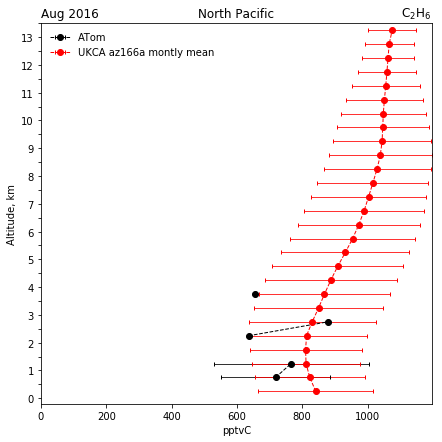

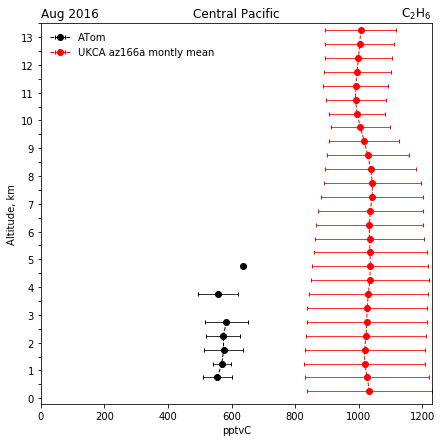

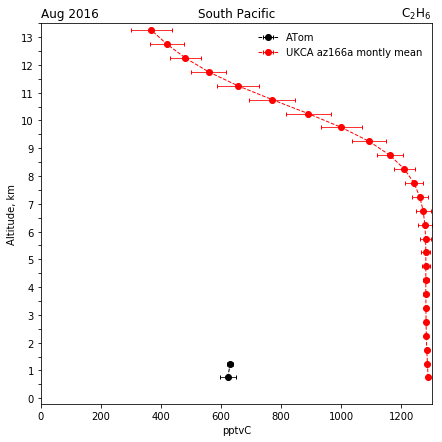

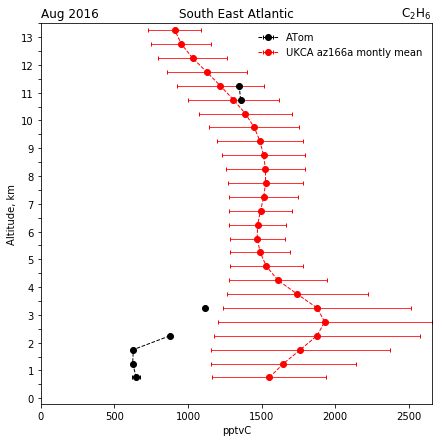

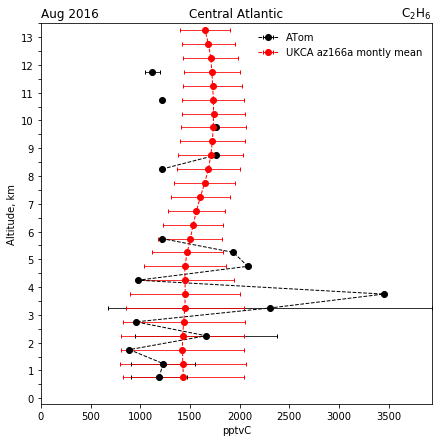

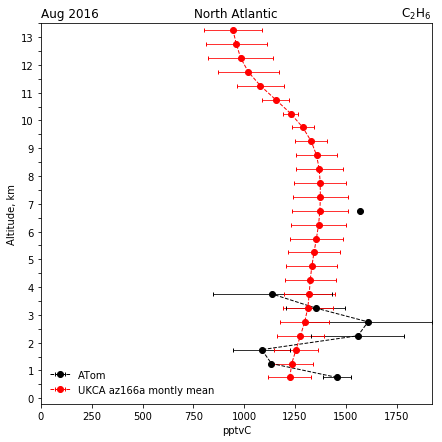

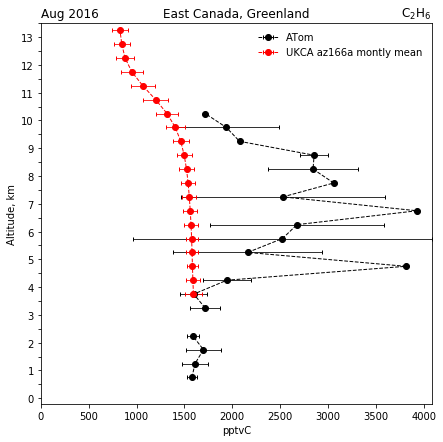

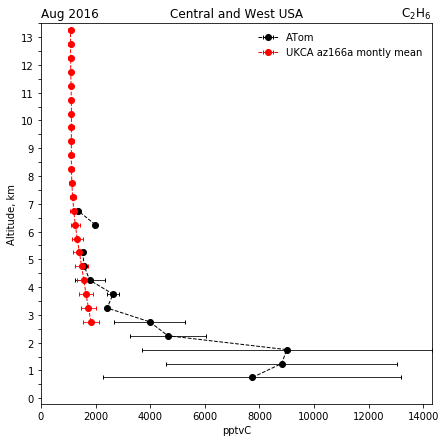

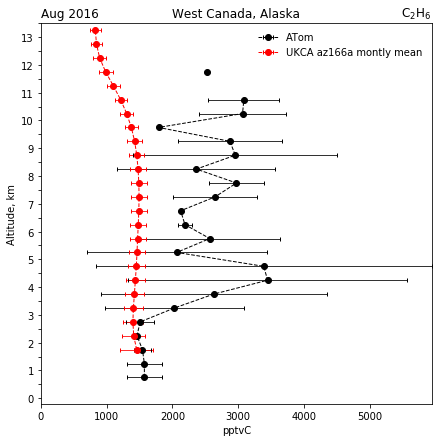

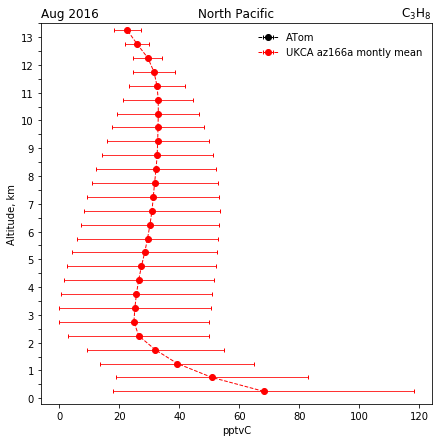

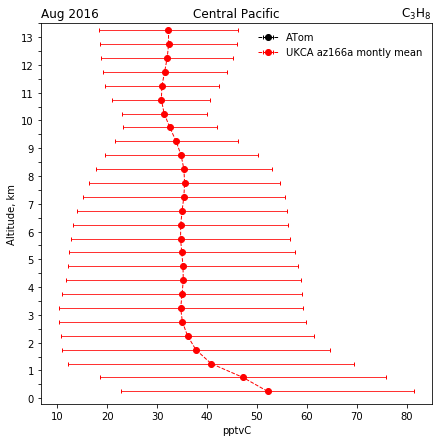

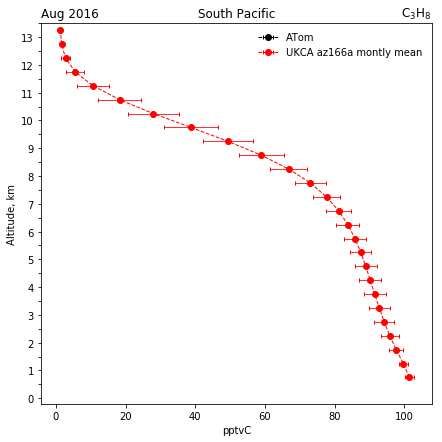

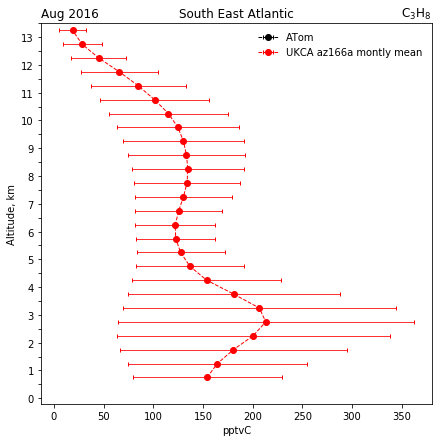

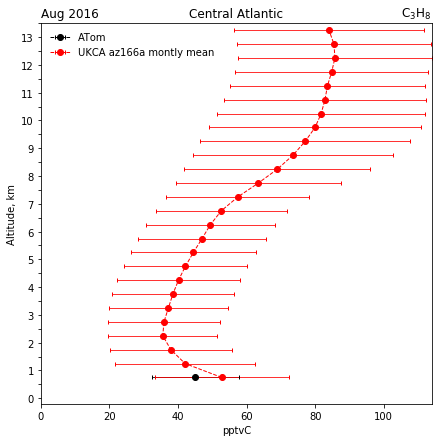

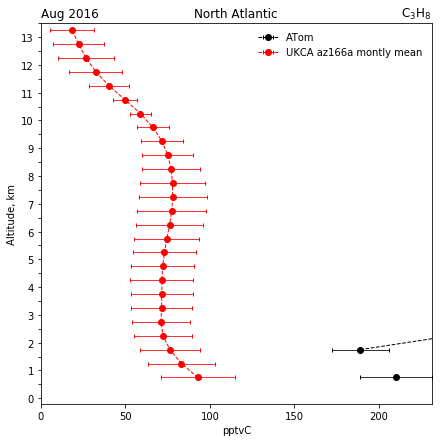

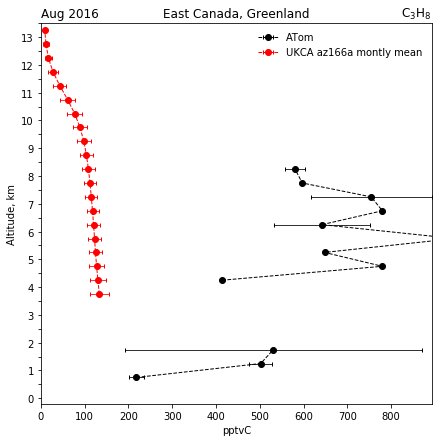

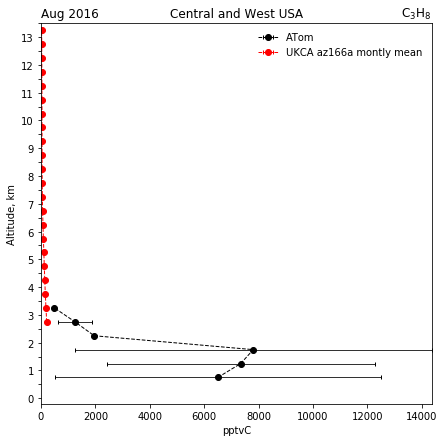

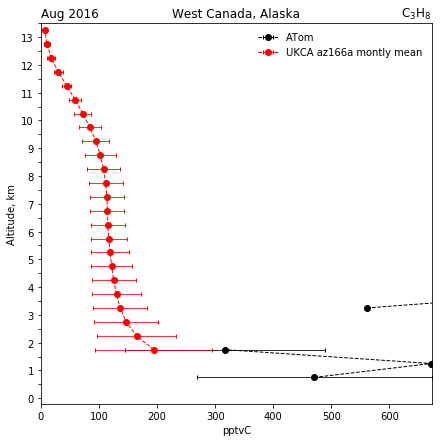

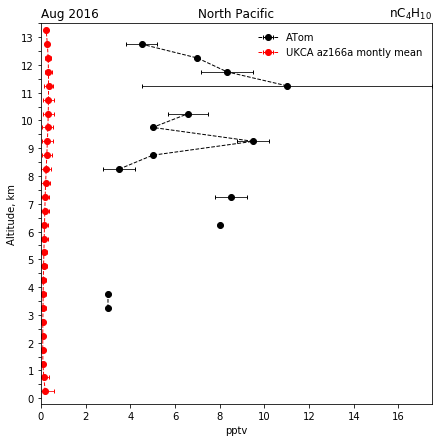

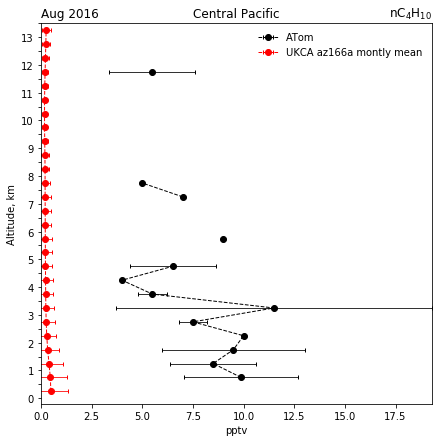

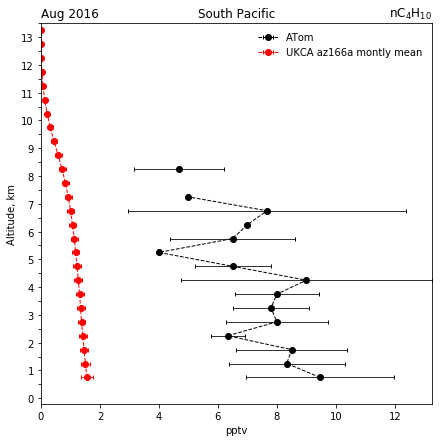

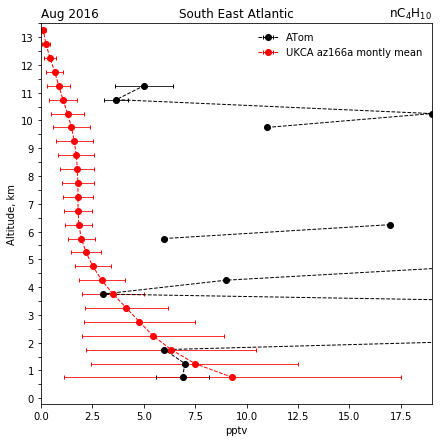

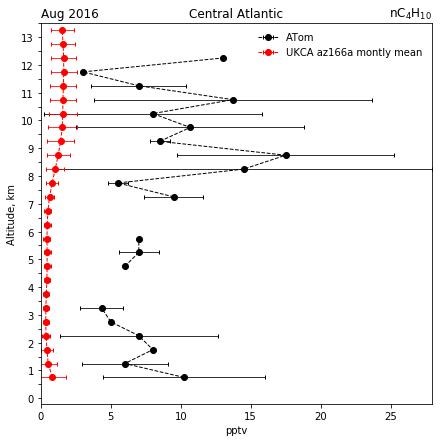

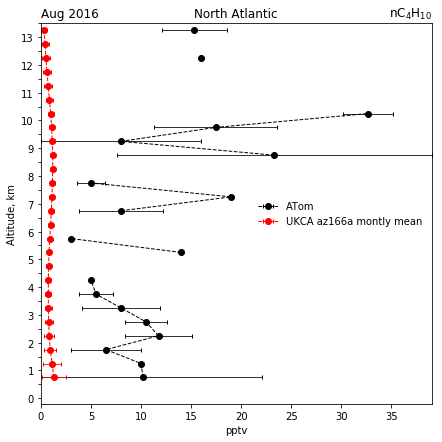

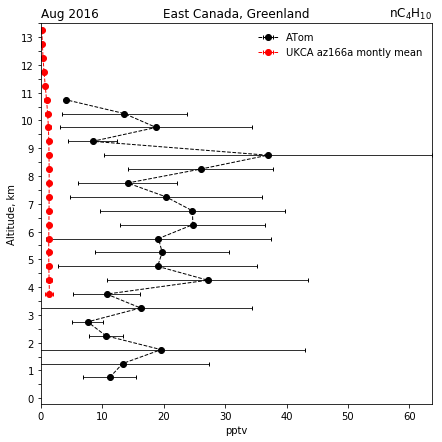

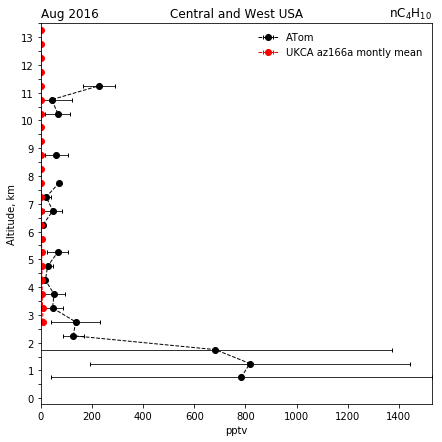

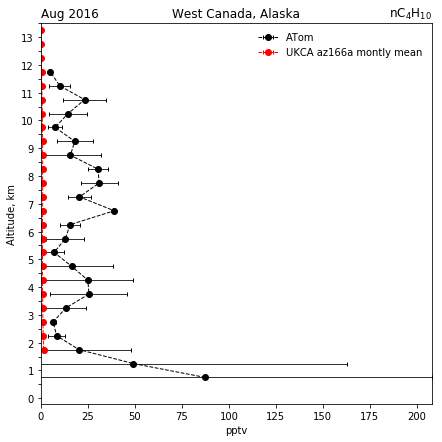

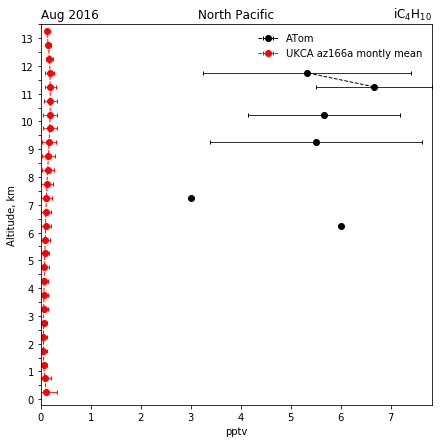

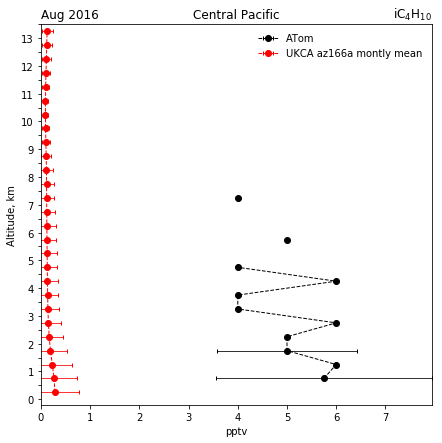

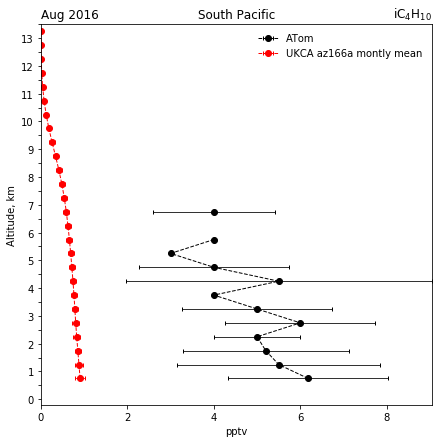

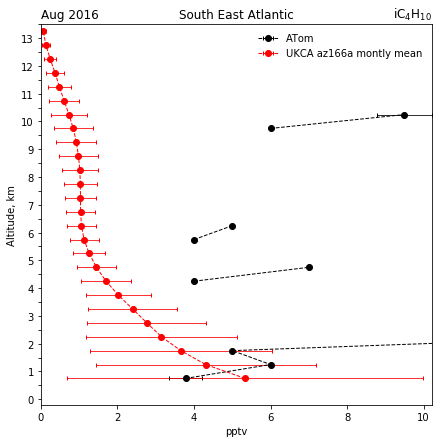

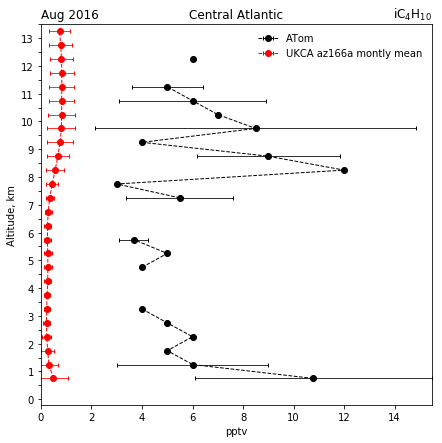

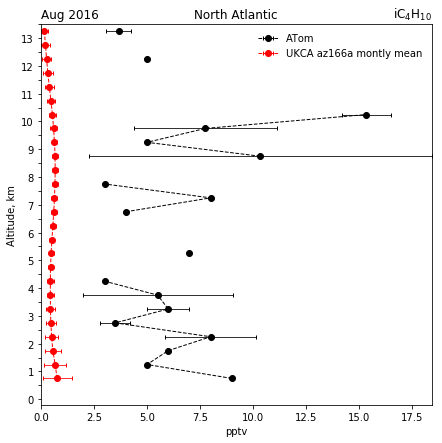

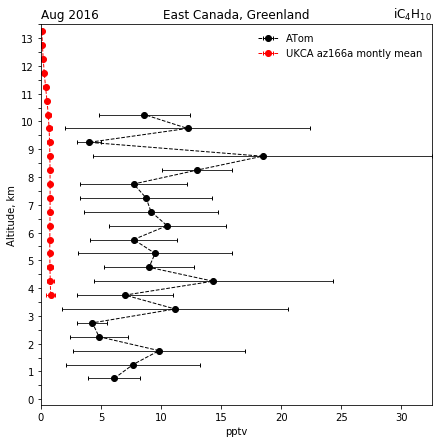

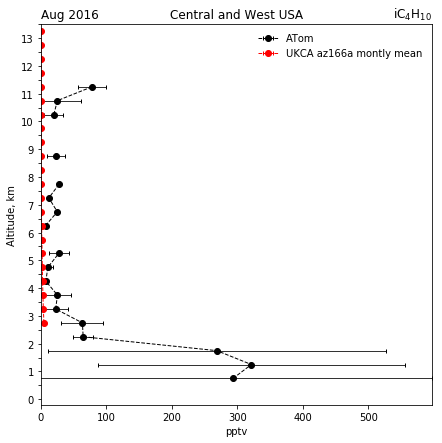

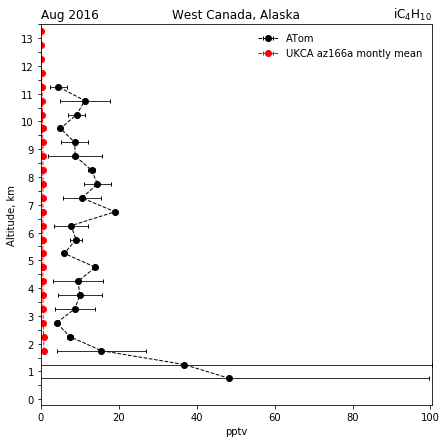

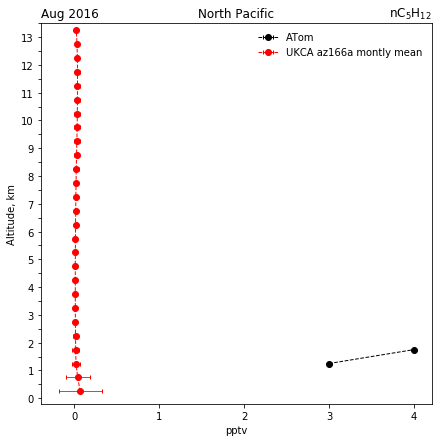

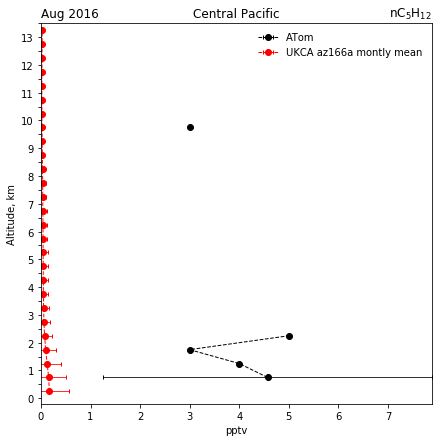

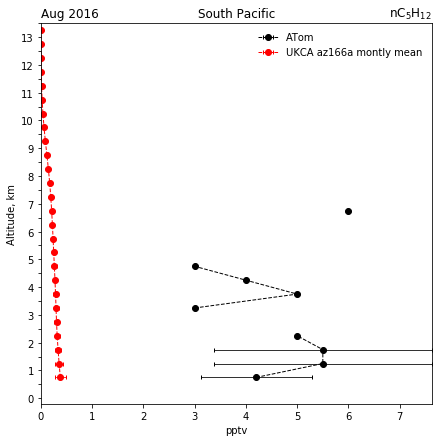

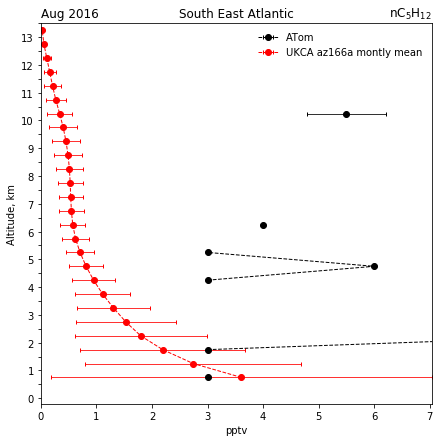

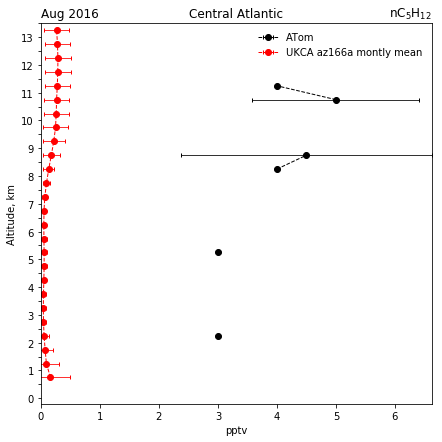

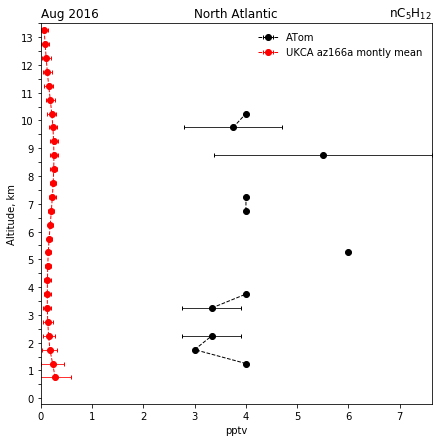

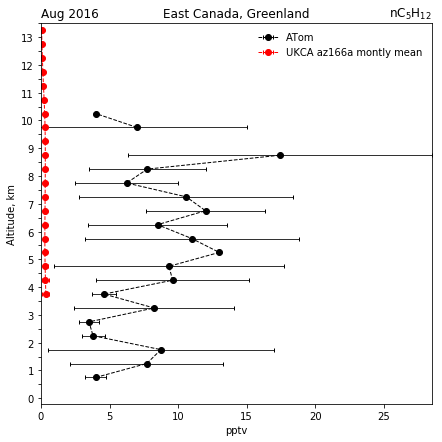

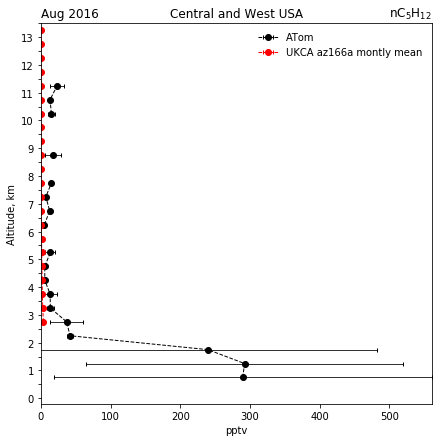

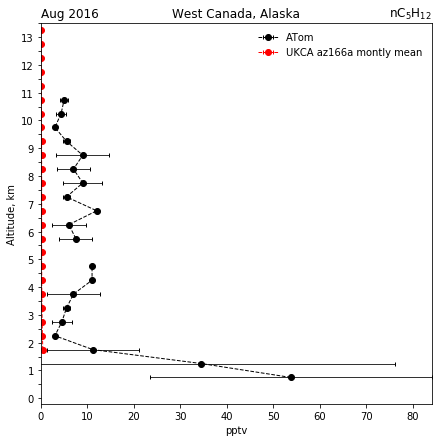

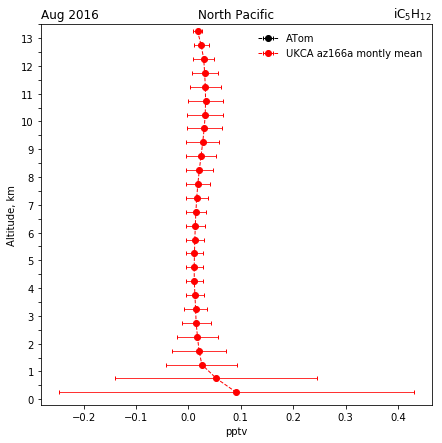

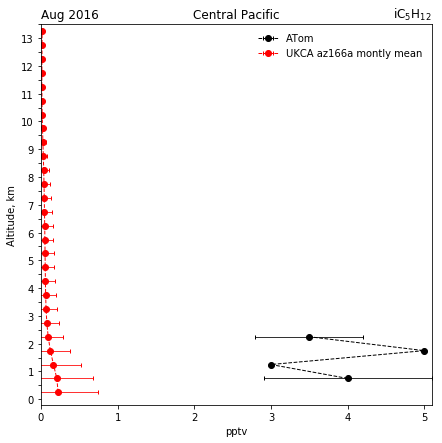

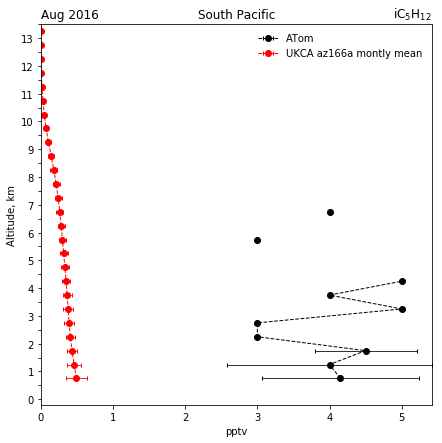

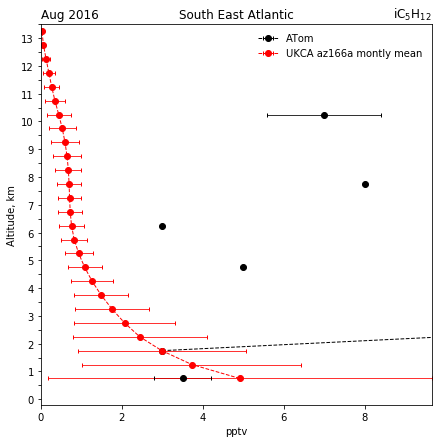

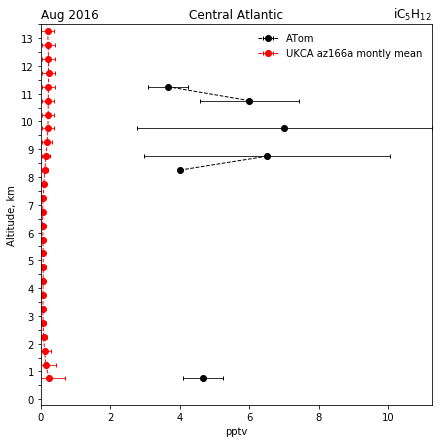

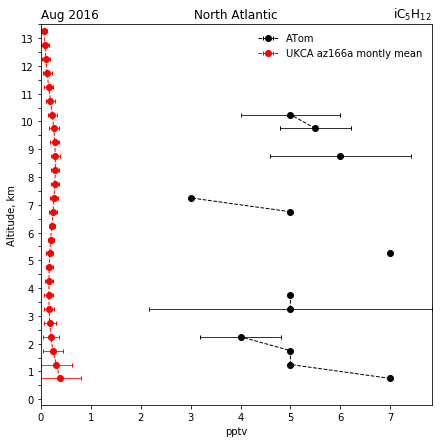

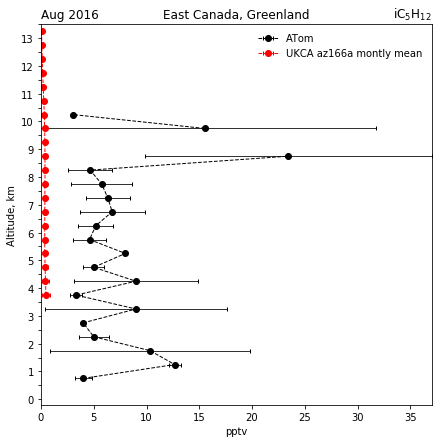

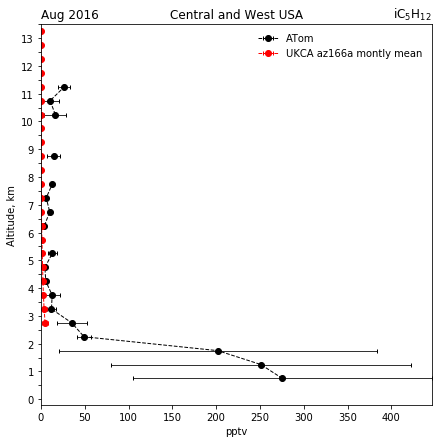

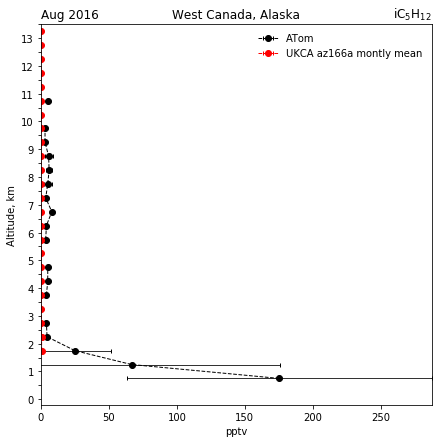

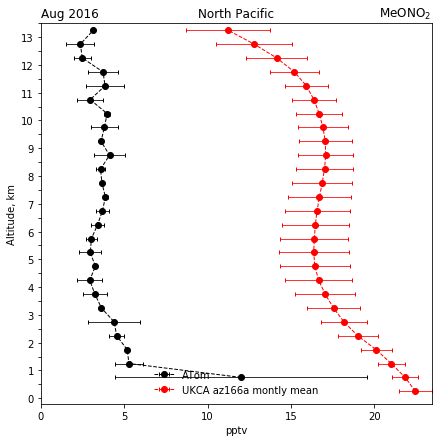

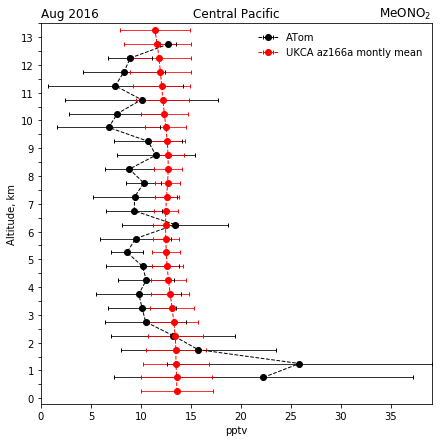

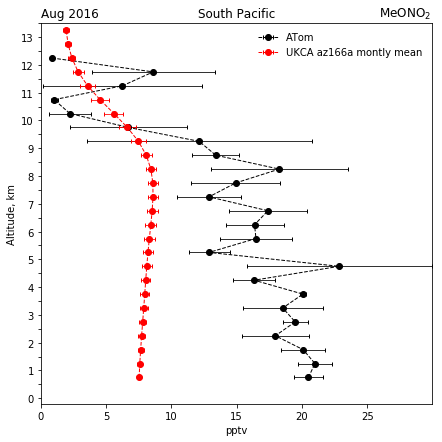

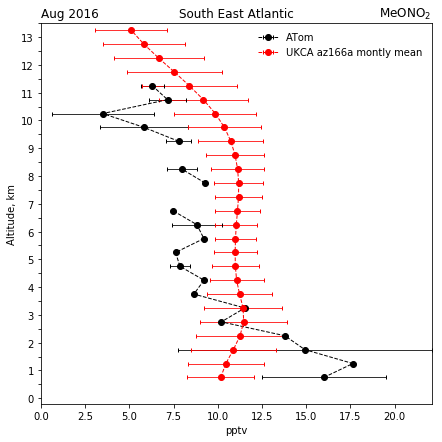

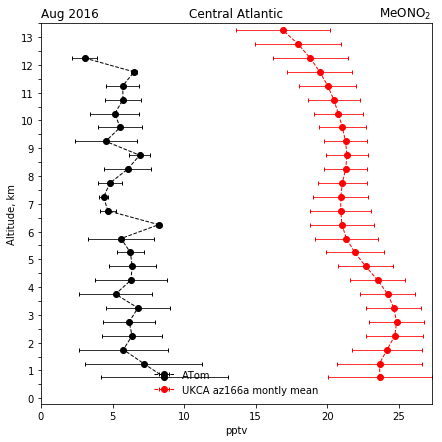

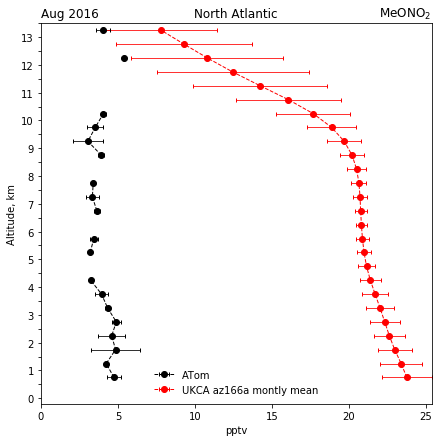

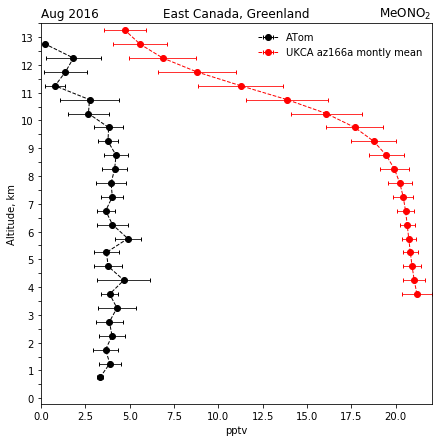

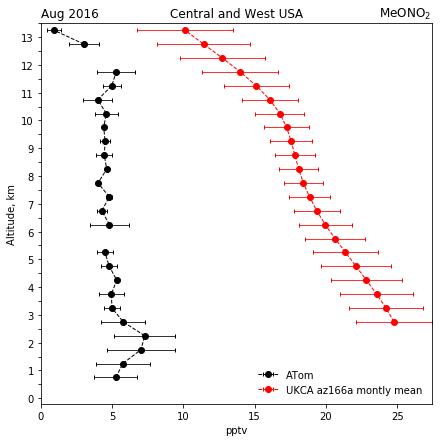

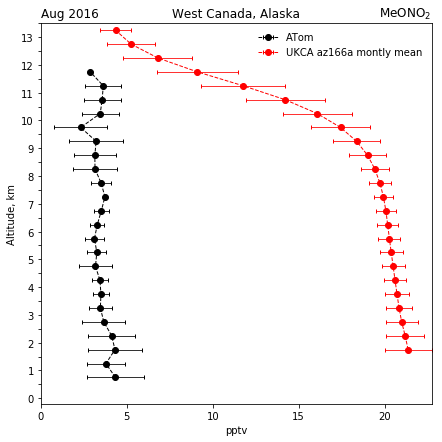

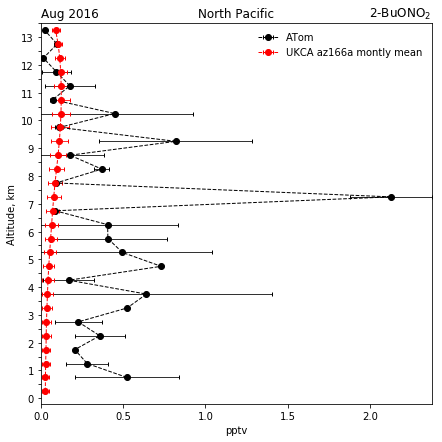

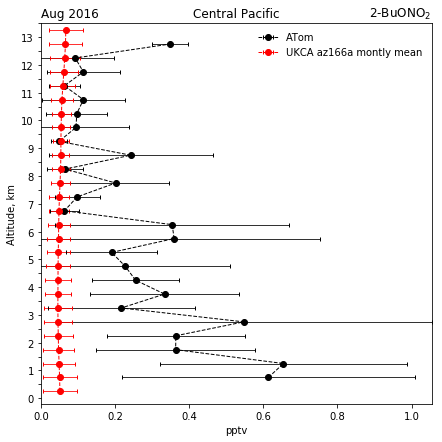

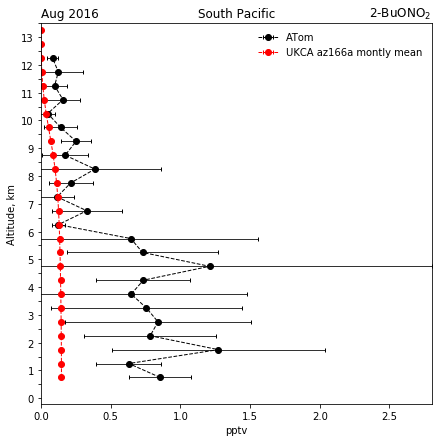

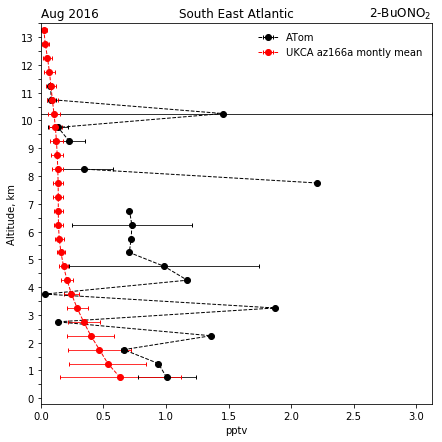

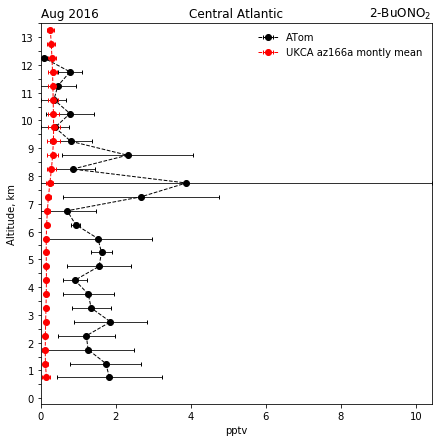

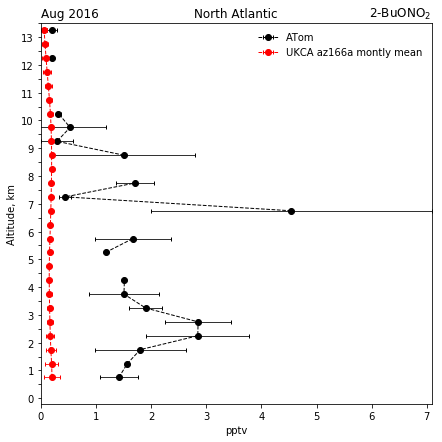

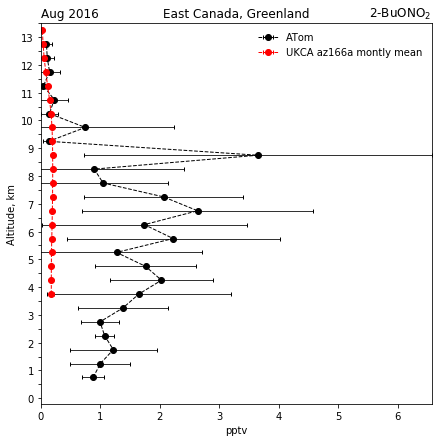

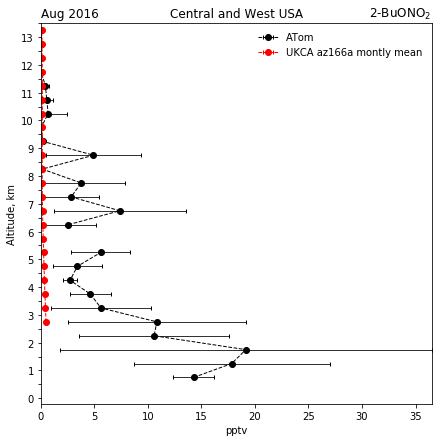

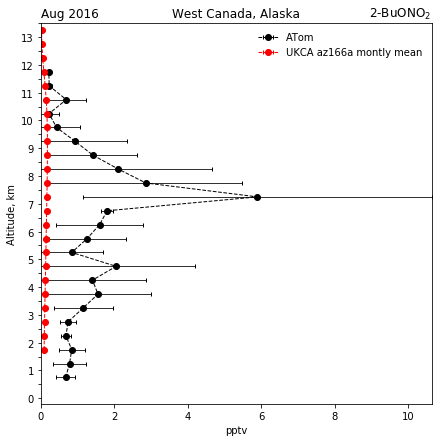

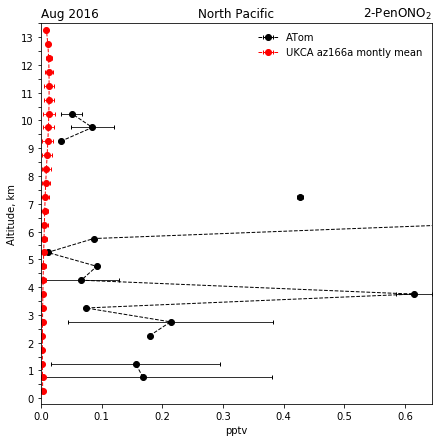

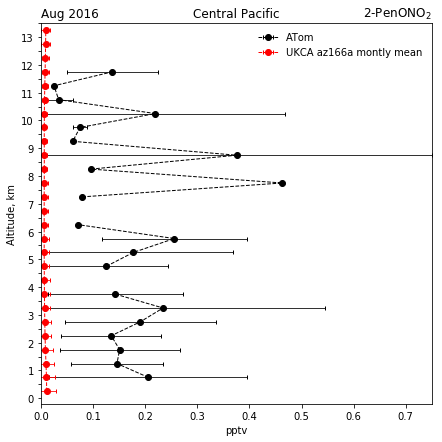

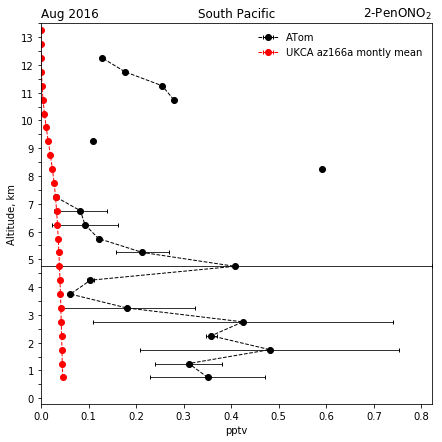

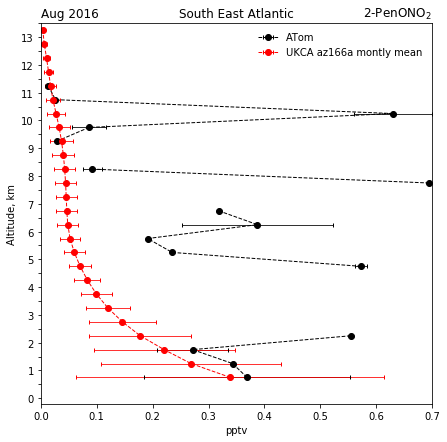

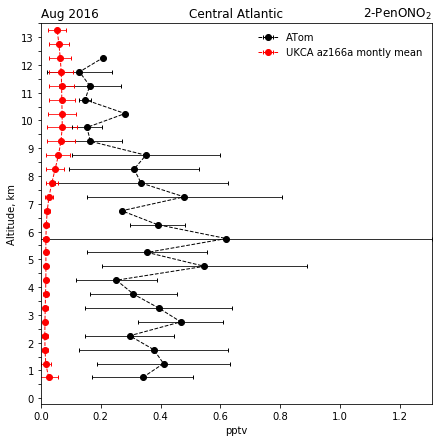

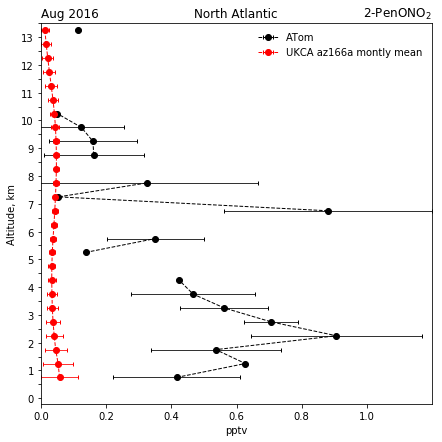

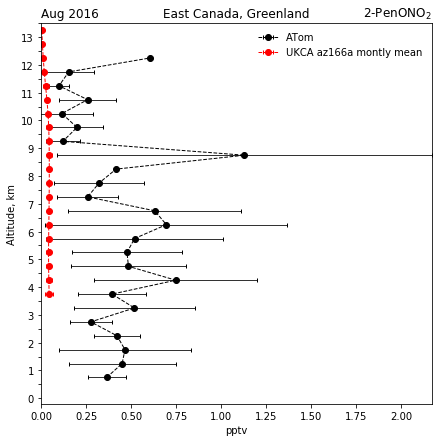

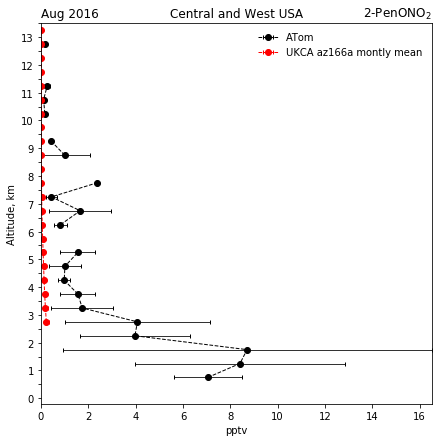

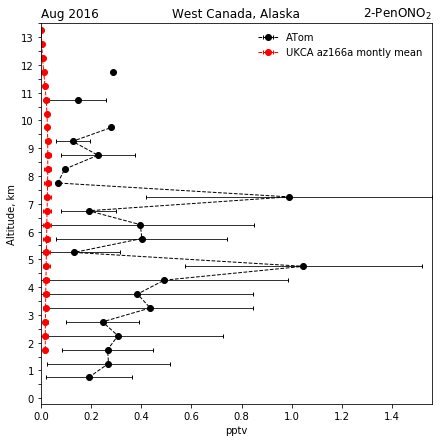

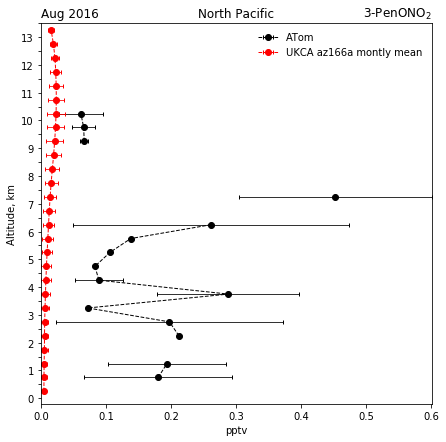

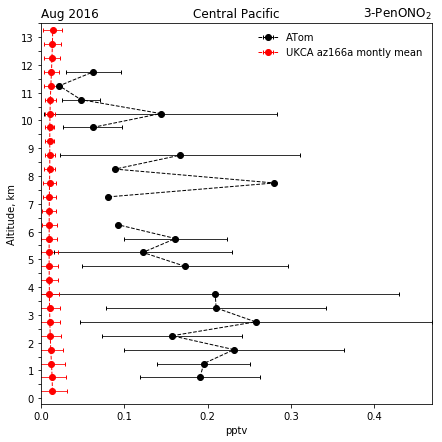

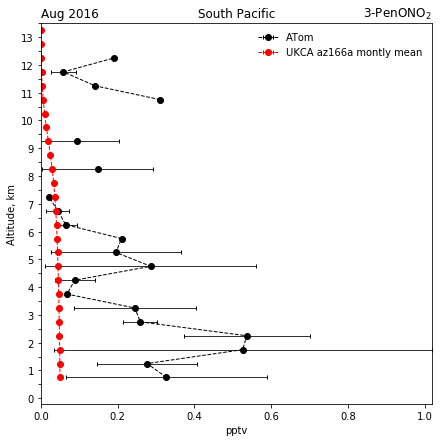

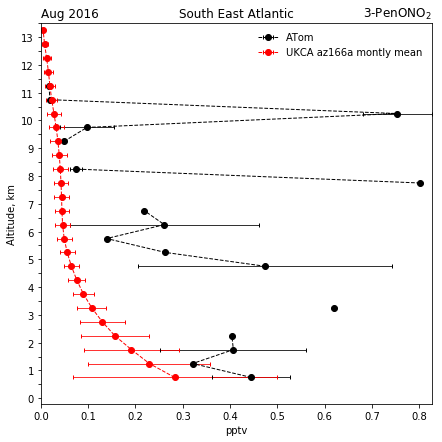

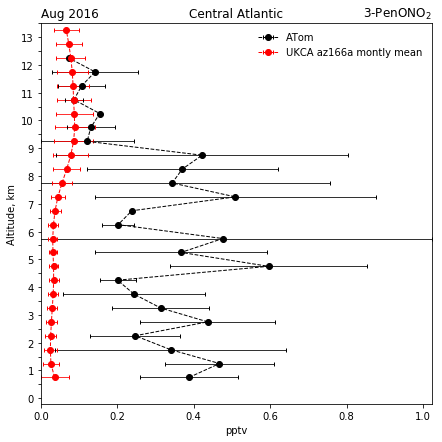

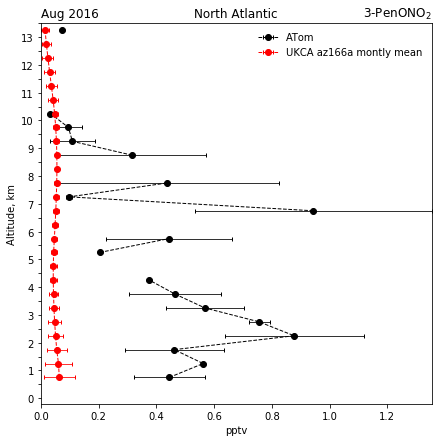

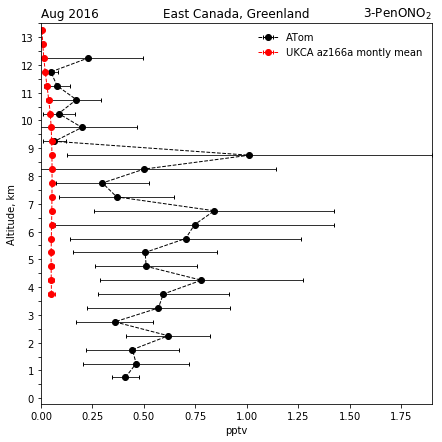

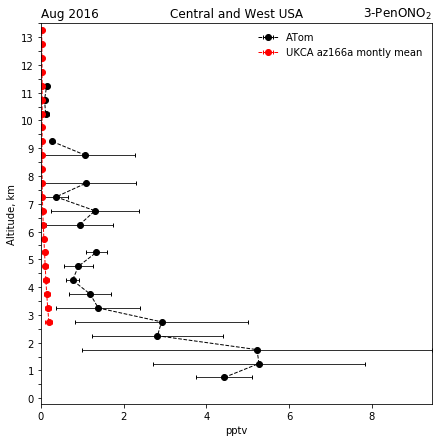

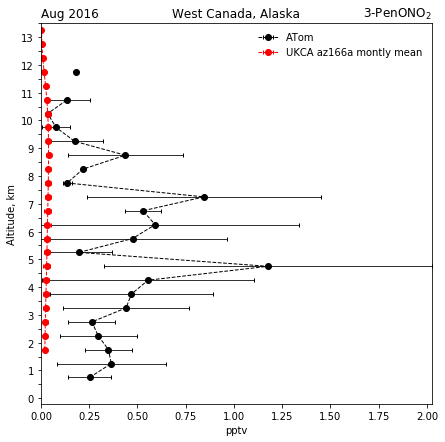

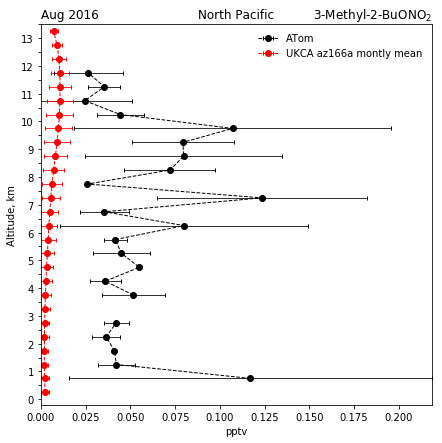

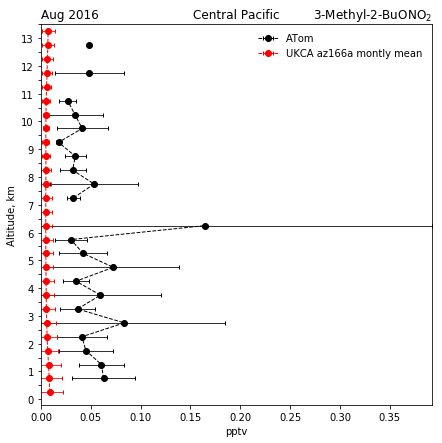

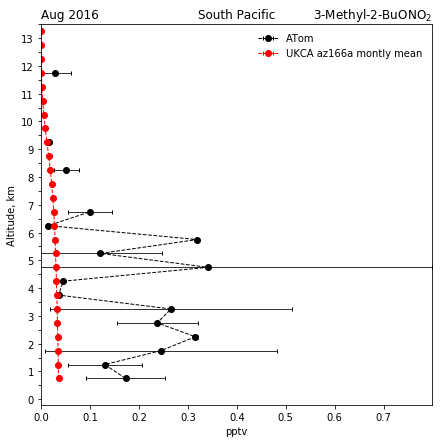

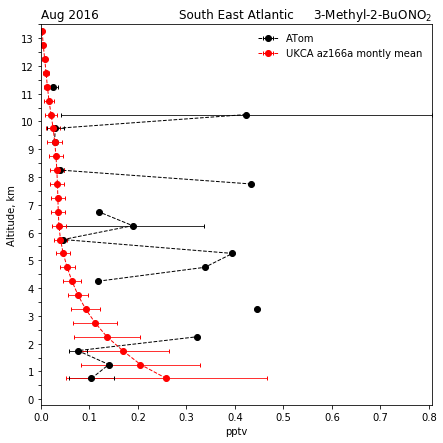

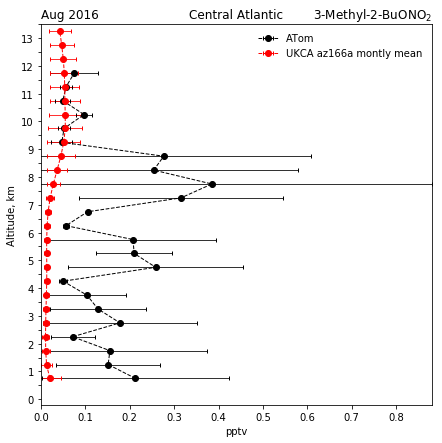

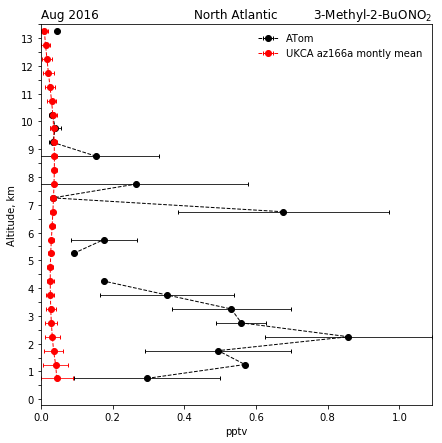

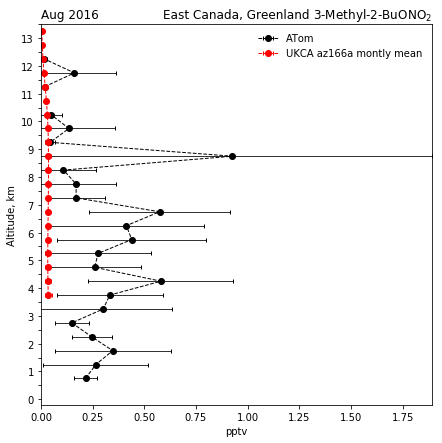

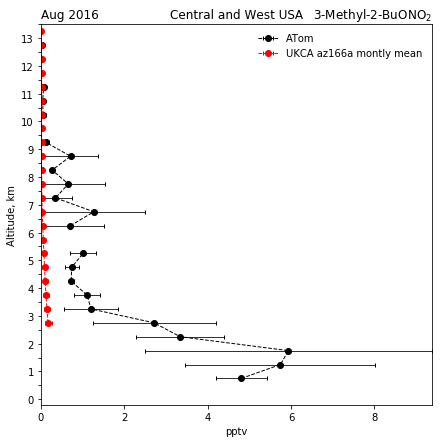

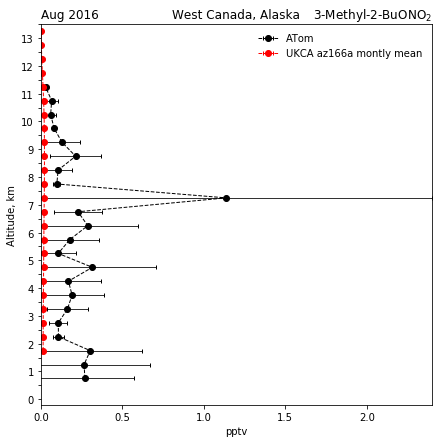

In [34]:
for specie, specie_dict in species_names_dict.items():
    if specie in ['c2h6', 'c3h8']:
        ppn = 'pptvC'
    else:
        ppn = 'pptv'
    for n, region_name in enumerate(region_names):
        plot_vp(atom_regional_vps[n][specie]['mean'].values, 
                ukca_regional_vps[n][specie]['mean'].data, 
                atom_regional_vps[n][specie]['std'].values, 
                ukca_regional_vps[n][specie]['std_dev'].data, specie_dict['latex'], ppn, region_name, n+1, specie_dict['fname'])